In [1]:
#%run /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/RotationCurveFit.py
#%run /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/ChainTool.py

import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../../../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_KLens)
from KLtool import *
from tfCube2 import TFCube

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import *
from RotationCurveFit import RotationCurveFit, GaussFit_signle
from ChainTool import ChainTool

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/branch_runs/tfCube2/../../../../KLens


# setup parameters

In [26]:
###### set up parameters ######
pars = {}
pars['g1'] = 0.0
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.25

pars['aspect'] = 0.2
pars['half_light_radius'] = 0.5
pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 1.0
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 6000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print(refSDSSspec)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist


###### setup slitAngles to major & minor axes ######

eint_thy = cal_e_int(sini=pars['sini'], q_z=pars['aspect'])
eobs_thy = cal_e_obs(e_int=eint_thy, g1=pars['g1'])
theta_obs = cal_theta_obs(g1=pars['g1'], g2=pars['g2'], theta_int=pars['theta_int'])

slitAng_major_p = theta_obs #0.001 #theta_obs    
slitAng_minor_p = theta_obs + np.pi/2. #np.pi/2. #theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

pars['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])
#pars['slitAngles'] = np.array([slitAng_major_p])


###### find flux_norm ######

flux_norm = find_flux_norm(pars, R=1.5)
print("flux_norm", flux_norm)

avgFlux_per_pix = avgFlux_in_R_per_pix(pars, flux_norm=flux_norm, R=1.5)
print("avgFlux_per_pix", avgFlux_per_pix)


##############################
line_species='Halpha'

2.9999999999999994e-16 erg / (cm2 nm s)
eobs_thy: 0.13636363636363635
slitAng_major_p: 21.008452488130185
slitAng_minor_p: 111.00845248813019
flux_norm 515.1985168457031
avgFlux_per_pix 1.0


In [27]:
slitAng_minor_p

1.9374629934615633

# run tfCube and make data_info file

In [28]:
###### image ######
GalIM = GalaxyImage(pars=pars, flux_norm=flux_norm)
obsImg, obsImgVariance = GalIM.observation(signal_to_noise=100.)

e_obs = GalIM.distorsion_int
modelImg = GalIM.model(e=e_obs, half_light_radius=pars['half_light_radius'], theta_int=pars['theta_int'], \
                       g1=pars['g1'], g2=pars['g2'])

###### spectra ######
TF = TFCube(pars=pars, line_species=line_species, flux_norm=flux_norm, sky_norm=1.)

modelSpec = TF.model2D(vcirc=TF.pars['vcirc'], sini=TF.pars['sini'], \
                       g1=TF.pars['g1'], g2=TF.pars['g2'], vscale=TF.pars['vscale'], \
                       v_0=TF.pars['v_0'], r_0=TF.pars['r_0'], theta_int=TF.pars['theta_int'], \
                       slitAngles=TF.pars['slitAngles'])

# obsCube = TF.observation3D()
# obsSpec = TF.observation2D(obsCube=obsCube)

###### prepare data_info ######

data_info = {'spec':modelSpec, 
             'image':modelImg,    
             'image_variance': obsImgVariance,
             'spec_variance': TF.skySpec,
             'par_fid': TF.pars,
             'flux_norm': flux_norm}

# data_info = {'spec':obsSpec, 
#              'image':obsImg,    
#              'image_variance': obsImgVariance,
#              'spec_variance': TF.skySpec}

data_info['lambdaGrid'] = TF.lambdaGrid
data_info['spaceGrid'] = TF.spaceGrid
data_info['line_species'] = line_species
data_info['lambda_emit'] = pars['linelist']['lambda'][pars['linelist']['species']==line_species][0] #656.461 # Halpha [nm]

print('line_species',line_species)
print('lambda_emit',data_info['lambda_emit'])

line_species Halpha
lambda_emit 656.461


# 2D spec 

In [29]:
# init Fit tool
RotFit = RotationCurveFit(data_info, \
                          active_par_key = ['vcirc', 'sini', 'vscale', 'r_0', 'v_0', 'g1', 'g2', 'theta_int']) #

time cost in gaussFit_spec2D: 0.09682297706604004 (secs)
time cost in gaussFit_spec2D: 0.08893108367919922 (secs)


In [30]:
active_par_test = np.zeros(len(RotFit.active_par_key))
for j, item in enumerate(RotFit.active_par_key):
    active_par_test[j] = RotFit.par_fid[item]
active_par_test

array([2.e+02, 5.e-01, 5.e-01, 0.e+00, 0.e+00, 0.e+00, 5.e-02, 0.e+00])

In [31]:
chi2 = RotFit.cal_chi2(active_par=active_par_test)
chi2

37399.82782628678

In [32]:
%time loglike = RotFit.cal_loglike(active_par=active_par_test)
loglike

CPU times: user 214 µs, sys: 1 µs, total: 215 µs
Wall time: 218 µs


-18699.91391314339

In [33]:
active_par_test[0] = 190.
loglike = RotFit.cal_loglike(active_par=active_par_test)
loglike

-18698.497780135105

In [34]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:21<00:00, 141.48it/s]

Total MCMC time (mins): 0.3537099361419678


In [35]:
%run /Users/hhg/Research/kinematic_lensing/repo/BinnedFit/ChainTool.py
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

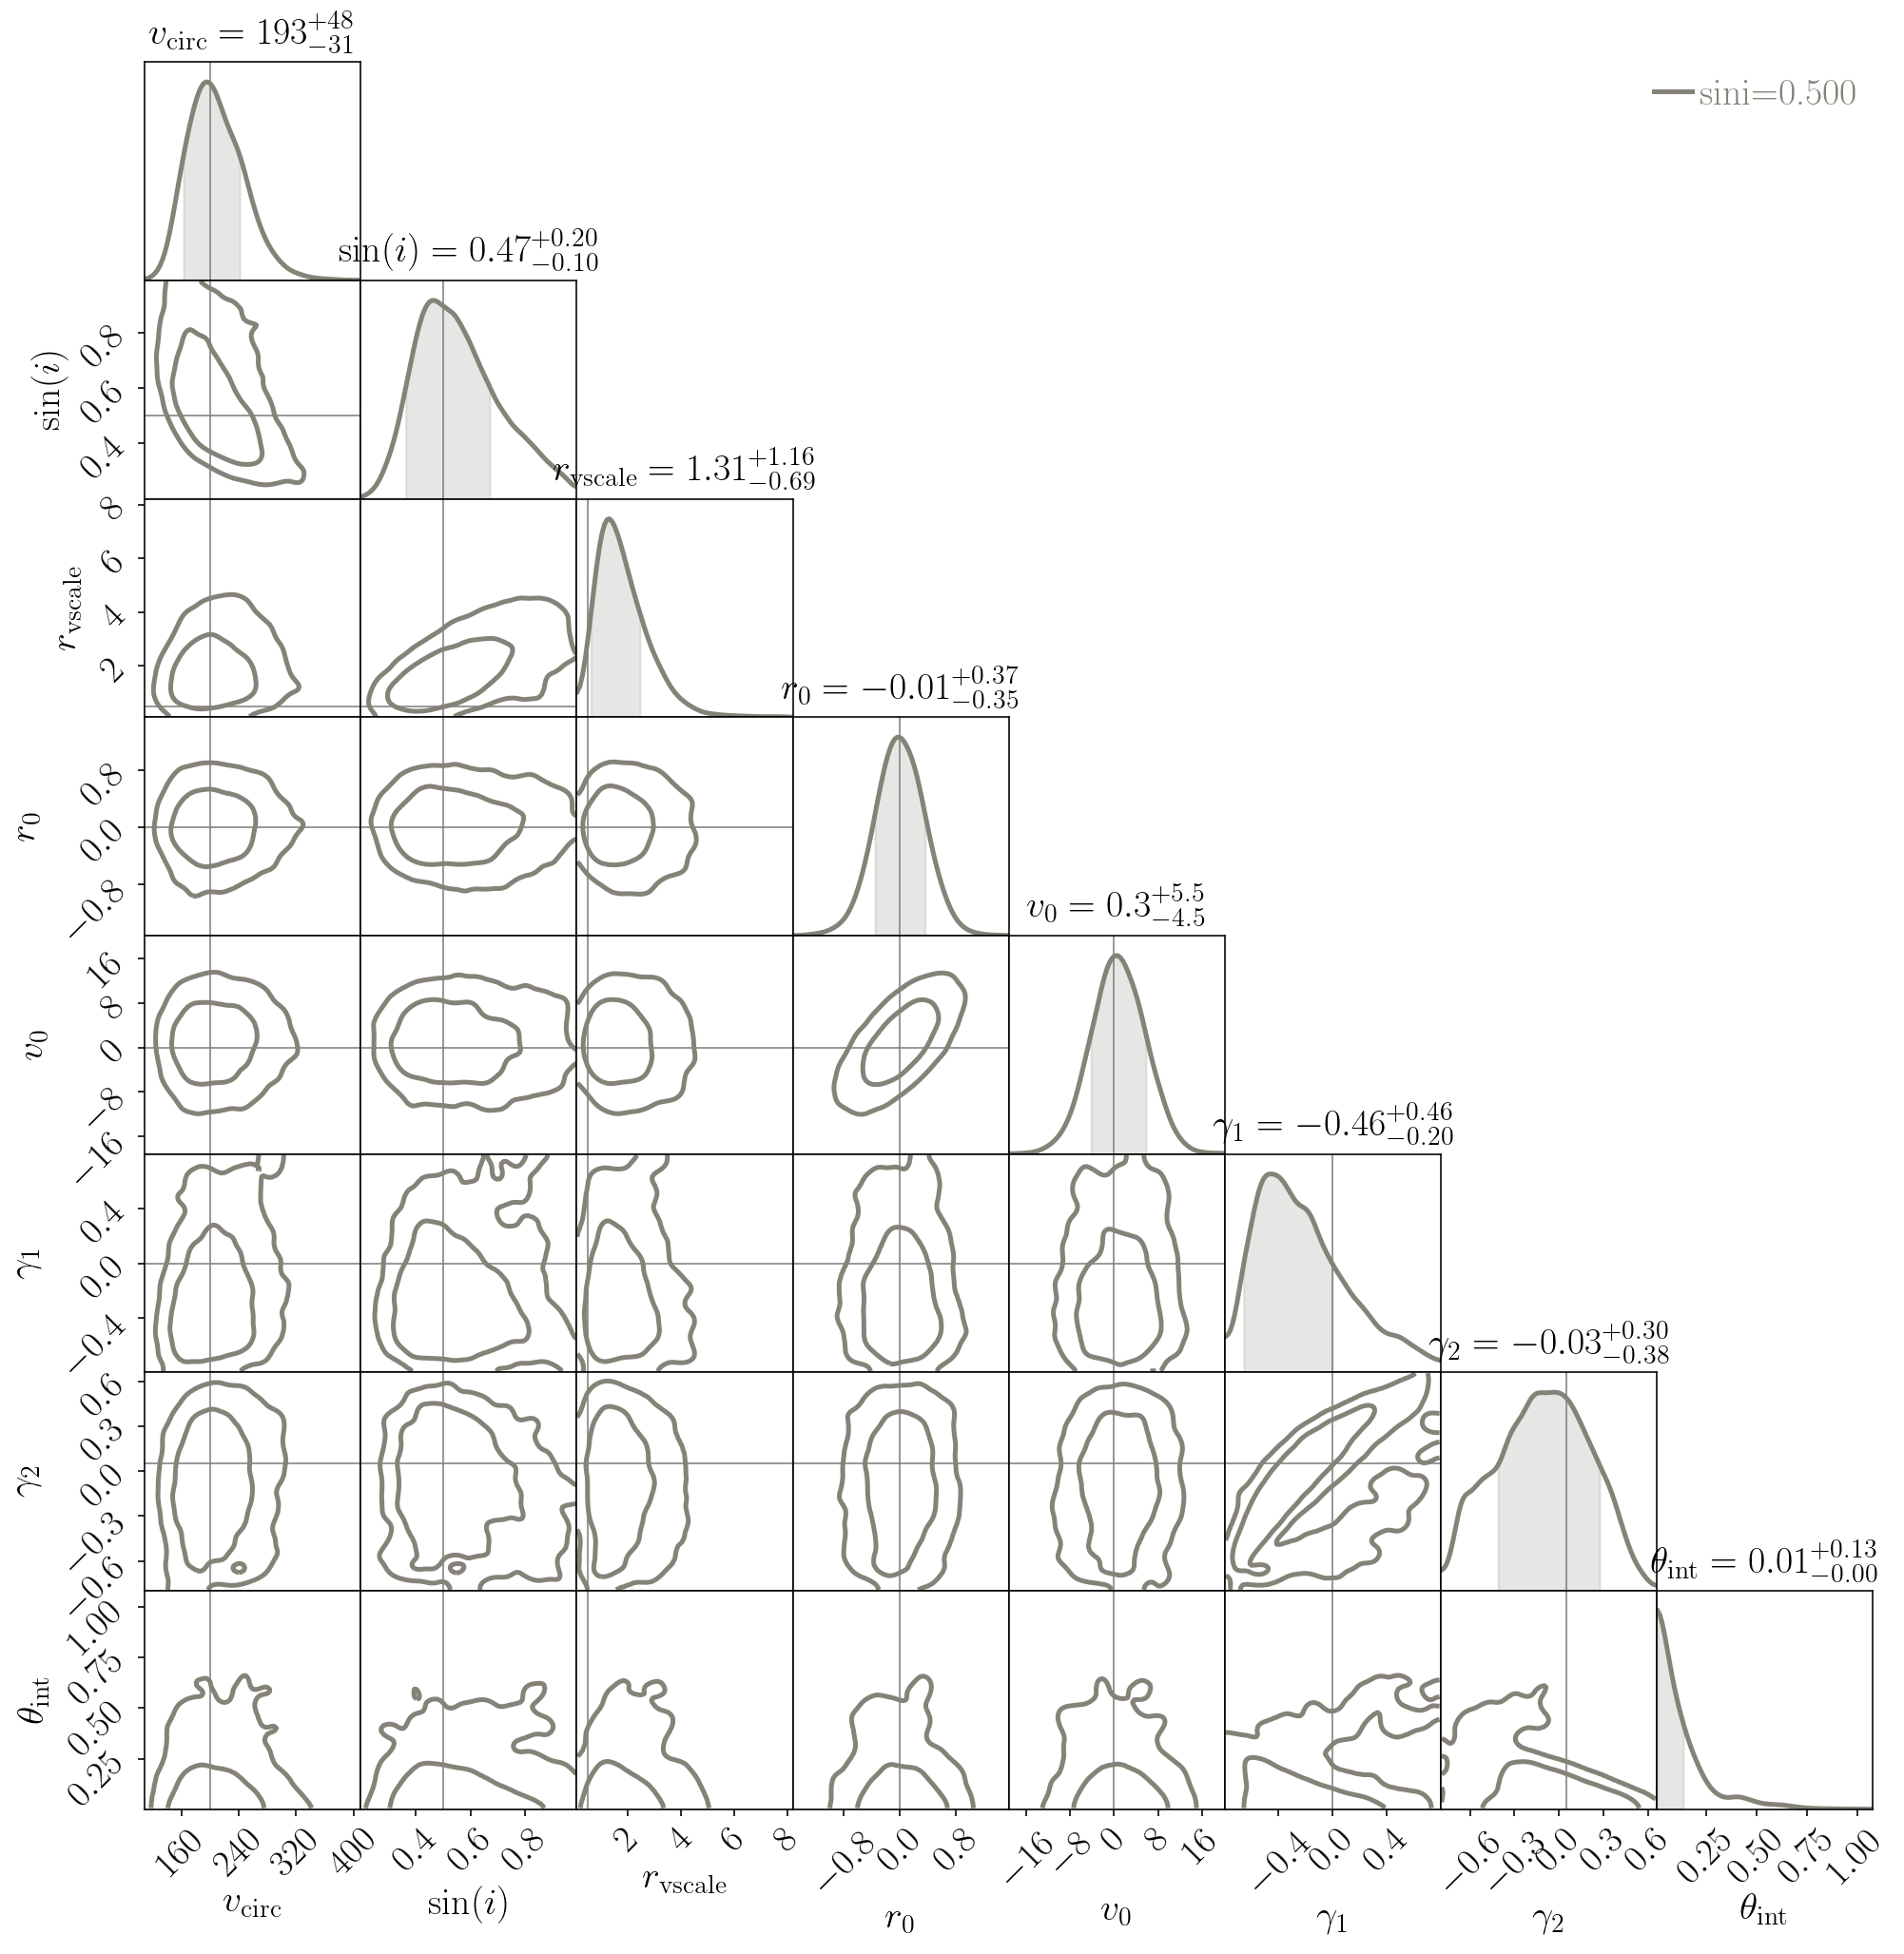

In [36]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = RotFit.active_par_key #, 'vscale' , 'sini'
legend_chain = "sini=%.3f"%pars['sini']

parID1, parName1, par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
#fig.savefig("fig1.pdf", transparent=True)

# Plot spectrum

In [37]:
# get pixel edges
lambda_min = np.min(RotFit.lambdaGrid)  ; lambda_MAX = np.max(RotFit.lambdaGrid)
x_min = np.min(RotFit.spaceGrid)        ; x_MAX = np.max(RotFit.spaceGrid)

lambda_emit = RotFit.lambda_emit
lambdaGrid, spaceGrid = RotFit.lambdaGrid, RotFit.spaceGrid

time cost in gaussFit_spec2D: 0.08715701103210449 (secs)


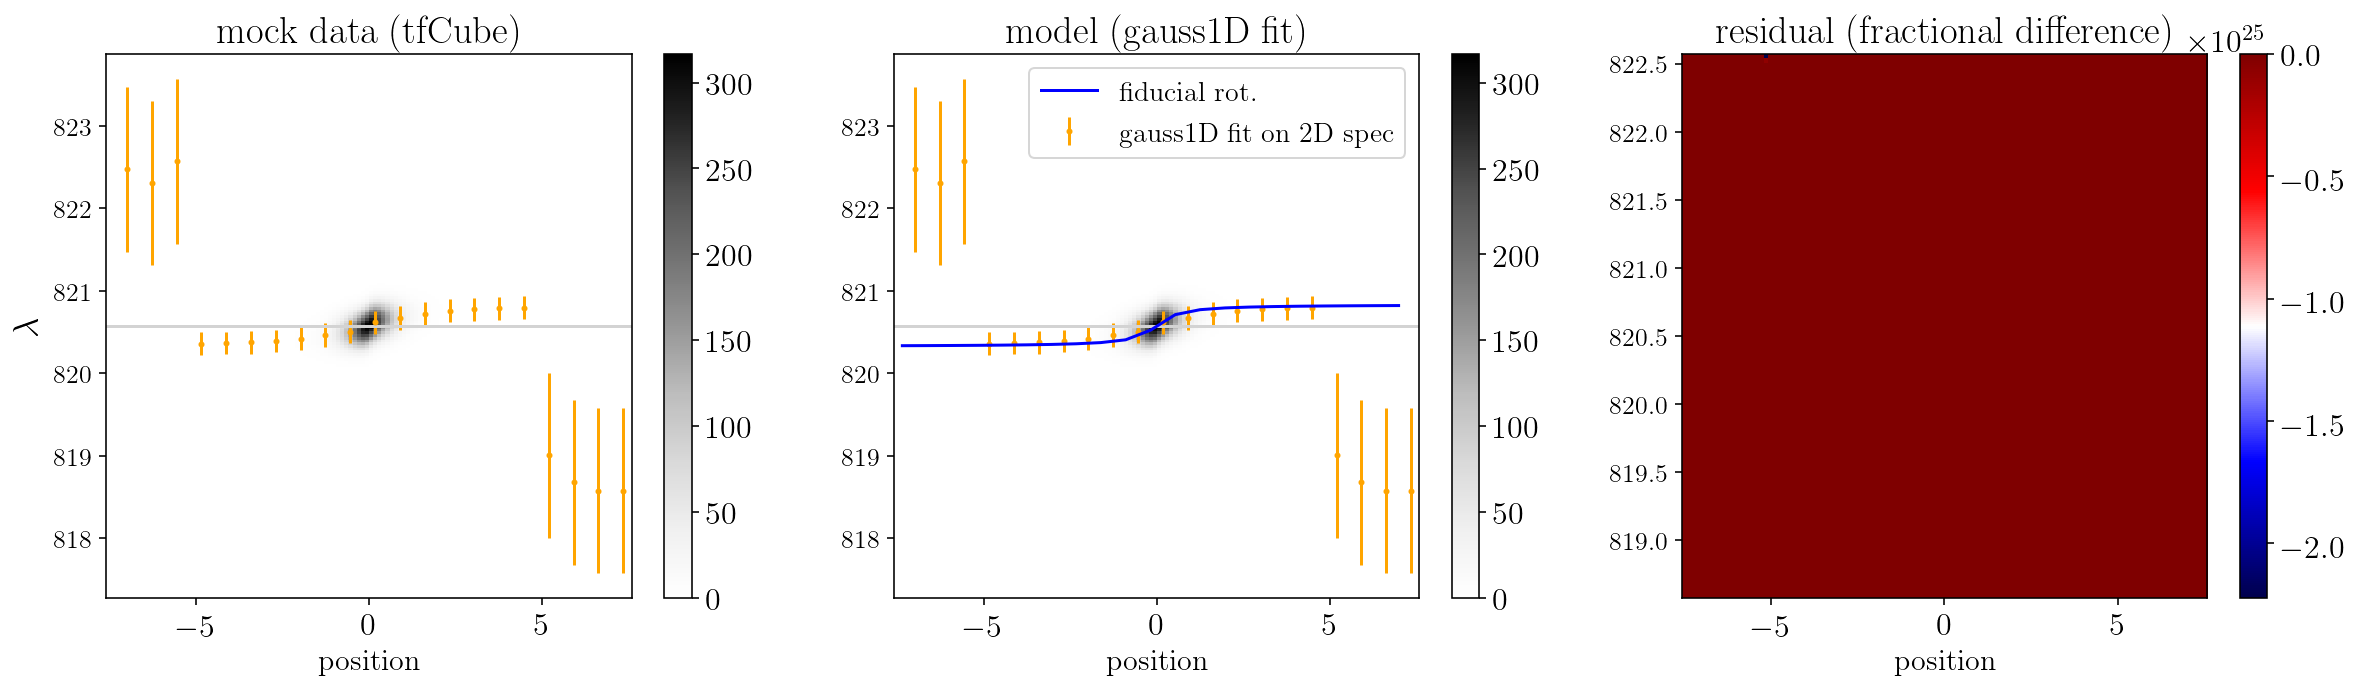

In [38]:
j=0
data = RotFit.spec[j]

GaussFit = GaussFit_signle(spec2D=data, lambda_emit=lambda_emit, lambdaGrid=lambdaGrid, spaceGrid=spaceGrid)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(spec2D=data)
model = GaussFit.model_spec2D(fitted_peakLambda, fitted_amp, fitted_sigma)

%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data.T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(model.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img2=ax[2].imshow((data.T-model.T)/data.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")
fig.colorbar(img2, ax=ax[2])
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])


#### gaussfit image peak identification summary (yellow)
ax[1].errorbar(spaceGrid[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')
ax[0].errorbar(spaceGrid[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')


#### result of fiducial rotation curve (black)
par_fid = RotFit.par_fid.copy()
fidicual_rot = RotFit.model_arctan_rotation(r=spaceGrid, vcirc=par_fid['vcirc'], sini=par_fid['sini'], \
                                           vscale=par_fid['vscale'], r_0=par_fid['r_0'], v_0=par_fid['v_0'], \
                                           g1=par_fid['g1'], g2=par_fid['g2'], theta_int=par_fid['theta_int'], \
                                           redshift=par_fid['redshift'], slitAngle=par_fid['slitAngles'][j])

# theta_test = 120.
# theta_test = theta_test * np.pi/180.
# fidicual_rot = RotFit.model_arctan_rotation(r=spaceGrid, vcirc=par_fid['vcirc'], sini=par_fid['sini'], \
#                                             vscale=par_fid['vscale'], r_0=par_fid['r_0'], v_0=par_fid['v_0'], \
#                                             g1=par_fid['g1'], g2=par_fid['g2'], theta_int=par_fid['theta_int'], \
#                                             redshift=par_fid['redshift'], slitAngle=theta_test)
ax[1].plot(spaceGrid[2::6],fidicual_rot[2::6],color='b',ls='-',label='fiducial rot.', zorder=10)


#### result of bestfit from MCMC sampling (red)
# par_BF_MC = Chain.par_bestfit(select_par_key=None, statistics='max', mode=0)

# MC_rot = RotFit.model_arctan_rotation(spaceGrid, vcirc=par_BF_MC['vcirc'][1], \
#                                       sini=par_BF_MC['sini'][1], vscale=par_BF_MC['vscale'][1], \
#                                       r_0=par_BF_MC['r_0'][1], v_0=par_BF_MC['v_0'][1], \
#                                       redshift=par_fid['redshift'], slitAngle=par_fid['slitAngles'][j])

# ax[1].plot(spaceGrid[2::6],MC_rot[2::6],color='r',ls='--',label='arctan rot (MCMC)')


lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])

ax[1].axhline(lambda_cen, color='lightgray')
ax[0].axhline(lambda_cen, color='lightgray')


for j in range(ncol):
    #ax[j].set_ylim(786.5,789.0)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)
    #ax[j].set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual (fractional difference)')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()